- sampling occurs in the wet season (October - April)
- rainfall in the dry season (July - October) - prior to sampling

We're interested in the effect of rainfall on the population growth.
Assumes an exponential population growth $N_{t} = r_{t}N_{t-1} - c_{t}$

- Population growth in the first year is unknown
- $r_{t}$ is a function of rainfall.

Observation model is the same as before $y_{t}|N_{t} \sim \mathcal{N}(N_{t}, \sigma^{2})$

Growth rate $r_{t} = e^{\beta_{0} + \beta_{1}rain}$
Modelled as an exponential function to avoid negative values. An alternative we could consider modelling the square root of rainfall, in that case $r_{t} = (\beta_{0} + \beta_{1}rain)^{2}$

### Prior specification: Define and justify appropriate priors for each of the parameters in the model

We will consider priors for $\beta_{0}$ and $\beta_{1}$, where $\beta_{0}$ represents the intercept of the model considered for the growth rate and $\beta_{1}$ the slope of the linear model. We will model the log of the growth rate, in order to avoid having negative growth rate values. An alternative for this model is to model the square root of the growth rate (with the power link function) instead of the exponential. This model would make sure as well that the growth rate will always take positive values. 

Because we don't have any prior knowledge of what suitable values for $\beta_{0}$ and $\beta_{1}$ should be considered, we will use uninformative priors. 
One solution is to consider priors modeled as a Uniform distribution, Uniform(0, $T$) with $T$ large, to account for a high range of possible values, equally probable. The problem with choosing a Uniform distribution on this range would be that this would consider values in interval (0, $T$) and this would be too restrictive for $\beta_{0}$ and $\beta_{1}$. To fix this we could consider a Uniform on ($-T$, $T$) that could sample negative values as well. An alternative is to consider a Normal distribution with a very low precision (or very high variance), such as $\mathcal{N}(0, \tau=0.00001)$ where $\tau$ is the precision. Further alternatives for setting the priors would be to consider prior elicitation using an expert in the domain or to consider a hierarchical model where $T$ or $\tau$ (or $\sigma$) could be further modeled as random variables rather than fixed constants. For the purpose of this modelling we will use:

- $\beta_{0} \sim \mathcal{N}(0, \tau=0.00001)$
- $\beta_{1} \sim \mathcal{N}(0, \tau=0.00001)$

Additionally, we need to consider priors for $\sigma_{N}$ and $\sigma_{y}$. In this case we need to consider distributions only on the positive range (because standard deviation cannot take negative values), and to account for the lack of knowledge of what these parameters could be, we will use uninformative priors as well. A range of possible solutions are as follows: 

- Truncated Normal distribution - truncated to allow only positive values
- LogNormal distribution
- Gamma (a very uninformative Gamma could be $\sim Gamma(\alpha=0.00001, \beta=0.00001)$)
- Uniform (0, $T$) with T positive. 

All of the above would be uninformative and keep the standard deviation positive. 
We will choose Uniform priors for the standard deviation of the process and observations because in general the Uniform distribution is less informative than the other ones specified above.

- $\sigma_{N} \sim U(0, 1)$
- $\sigma_{y} \sim U(0, 1)$

In BUGS, we could even specify a flat prior using $x \sim dflat()$

In [156]:
library(statsecol)
library(zoo)
library(jagsUI)
library(MCMCvis)
library(tibble)
data("wildebeest")

In [157]:
# Backfill missing data
wildebeest <- na.locf(wildebeest, fromLast=T)

Before we apply the modelling in the BUGS language, we will validate below if the exponential model is suitable to model the growth rate as a function of rain. This comes with a caveat because we have missing data that was backfilled previously. Regardless of this, we will still run an analysis to check the dependence between rain and growth rate. 

First we need to find the growth rate from the dataset available. For this we will consider $r_{t} = \frac{Nhat_{t+1}}{Njat_{t}}$ the growth rate between $Nhat_t$ and $Nhat_{t+1}$.

In [88]:
# we set the growth and fill the last row with zero, since the growth rate is not known
# last row will not be considered for the model anyways
wildebeest$growth <- c(wildebeest$Nhat[-1]/wildebeest$Nhat[-nrow(wildebeest)], 0)

growth_rain <- data.frame(
    Growth = wildebeest$growth[-nrow(wildebeest)],
    Rain = wildebeest$rain[-nrow(wildebeest)]
)

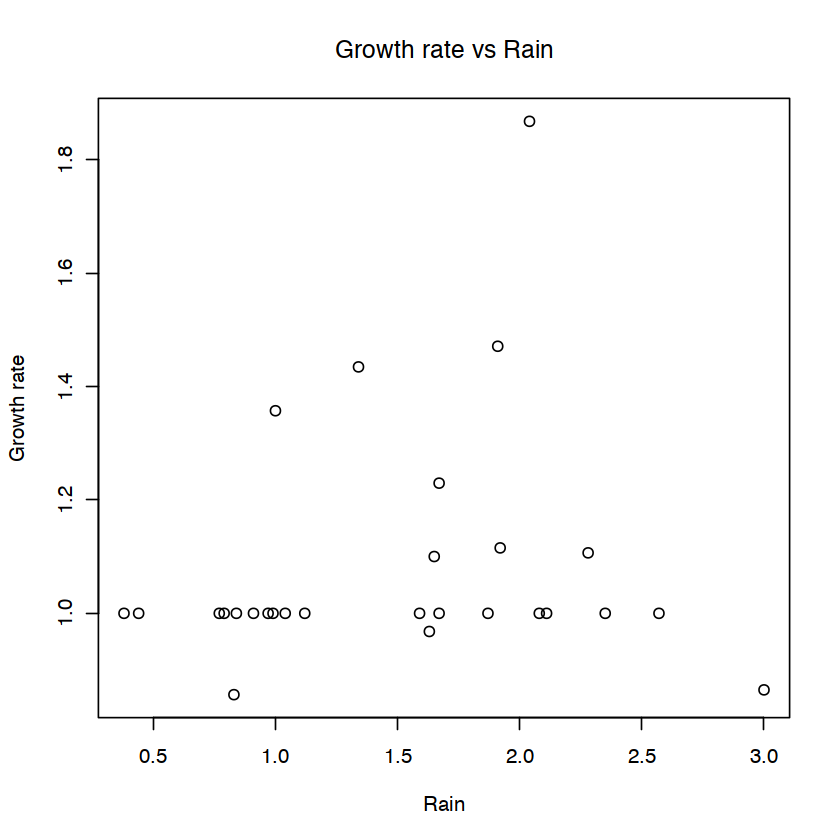

In [124]:
# Plot the growth rate vs rain. The goal is to inspect visually if there is any trend in the data
plot(growth_rain$Rain, growth_rain$Growth, xlab="Rain", ylab="Growth rate", main="Growth rate vs Rain")

With a correlation of only 0.13, the initial exploratory analysis doesn't seem to suggest that growth is well explained by rain.

First we consider a model that is modelling the square root of growth rate as a function of rain.

In [141]:
growth_rain$Sqrtgrowth <- sqrt(growth_rain$Growth)
linear_model <- lm(Sqrtgrowth ~ Rain, data=growth_rain)
round(anova(linear_model), 2)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rain,1,0.00,0.00,0.42,0.52
Residuals,26,0.23,0.01,NA,NA


Considering the square root of the growth as a function of rain doesn't seem to show a significant result (p-value 0.52). This means that the simple linear model, does not provide a good fit for the data. We will try an exponential model as initially intended.

In [108]:
fit <- glm(formula = Growth ~ Rain,  family = Gamma(link="log"), data=growth_rain)
round(anova(fit, test="F"), 2)

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NULL,NA,NA,27,0.84,NA,NA
Rain,1,0.02,26,0.82,0.51,0.48


Neither of these models seem to be significant, there could be two reasons why the growth might not be well explained by the rain. One is that the assumption that we can backfill data and consider a model with repeated yearly values is wrong. The second one is that in reality, it is very unlikely that the growth rate is just a function of rain. For the purpose of the practical, we will consider growth as a function of rain, as indicated in the project details.

### BUGS model description: Write the model above in the BUGS language

- $N_{t}|N_{t-1} \sim \mathcal{N}(r_{t}N_{t-1} - C_{t-1}, \sigma_{N}^{2})$
- $log(r_{t}) = \beta_{0} + \beta_{1}Rain_{t}$
- $y_{t}|N_{t} \sim \mathcal{N}(N_{t}, \sigma_{y}^{2})$

Growth rate $r_{t} = e^{\beta_{0} + \beta_{1}rain}$ modelled as an exponential function to avoid negative values. An alternative we could consider modelling the square root of growth rate, in that case $r_{t} = (\beta_{0} + \beta_{1}rain)^{2}$


In [145]:
sink("project2.txt")
cat("
model{

  # Priors and constraints
  log.N[1] ~ dnorm(N1, 0.01)
    
  b0 ~ dnorm(0, 0.00001)  # Prior for the Intercept
  b1 ~ dnorm(0, 0.00001)  # Prior for the slope

  sig.n ~ dunif(0, 1)     # Standard deviation for the population
  tau.n <- pow(sig.n, -2) # Precision for the state process
  
  sig.y ~ dunif(0, 1)     # Standard deviation for the observations process  
  tau.y <- pow(sig.y, -2) # Precision for the observation process

  for (t in 1: (nyrs-1)) {
    mu[t] = log(exp(r[t]) * exp(log.N[t]) - catch[t])
  }

  # Likelihood - State process
  for(t in 1:(nyrs-1)) {
    log(r[t]) <- log.r[t]       # Link function for the parameter
    log.r[t] <- b0 + b1*rain[t] # Linear model for the logarithm of the growth rate
    
    # We transform back the logarithm of r[t] and logarithm of N[t]
    # to be able to compute the mean log(r[t] * N[t] - catch[t])
    # for the log of N[t+1].  
    log.N[t+1] ~ dnorm(mu[t], tau.n)
  }

  # Likelihood - Observation process
  for (t in 1:nyrs) {
     y[t] ~ dnorm(log.N[t], tau.y)

  }

  # Derive population and observation sizes on real scale
  for (t in 1:nyrs) {
    # Transform from the logarithm scale by taking the inverse (exp(log(u)) = u)
    N.est[t] <- exp(log.N[t])
  }
}
", fill = TRUE)
sink()


model{

  # Priors and constraints
  log.n1 ~ dnorm(N1, 0.01) # Initial population size
  log.N[1] <- log.n1
    
  b0 ~ dnorm(0, 0.00001)  # Prior for the Intercept
  b1 ~ dnorm(0, 0.00001)  # Prior for the slope

  sig.n ~ dunif(0, 1)     # Standard deviation for the population
  tau.n <- pow(sig.n, -2) # Precision for the state process
  
  sig.y ~ dunif(0, 1)     # Standard deviation for the observations process  
  tau.y <- pow(sig.y, -2) # Precision for the observation process

  for (t in 1: (nyrs-1)) {
    mu[t] = log(exp(r[t]) * exp(log.N[t]) - catch[t])
  }

  # Likelihood - State process
  for(t in 1:(nyrs-1)) {
    log(r[t]) <- log.r[t]       # Link function for the parameter
    log.r[t] <- b0 + b1*rain[t] # Linear model for the logarithm of the growth rate
    
    # We transform back the logarithm of r[t] and logarithm of N[t]
    # to be able to compute the mean log(r[t] * N[t] - catch[t])
    # for the log of N[t+1].  
    log.N[t+1] ~ dnorm(mu[i], tau.n)
  }

  # Lik


Processing function input....... 

Done. 
 
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 30
   Unobserved stochastic nodes: 34
   Total graph size: 359

Initializing model

Adaptive phase..... 
Adaptive phase complete 
 

 Burn-in phase, 1e+05 iterations x 3 chains 
 

Sampling from joint posterior, 1e+05 iterations x 3 chains 
 

Calculating statistics....... 

Done. 


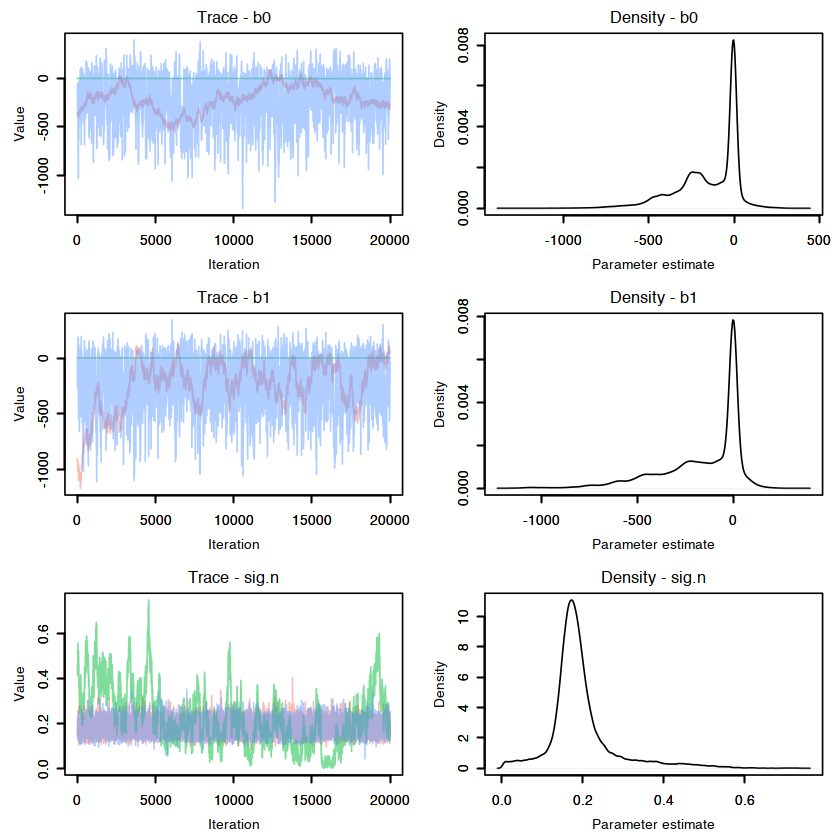

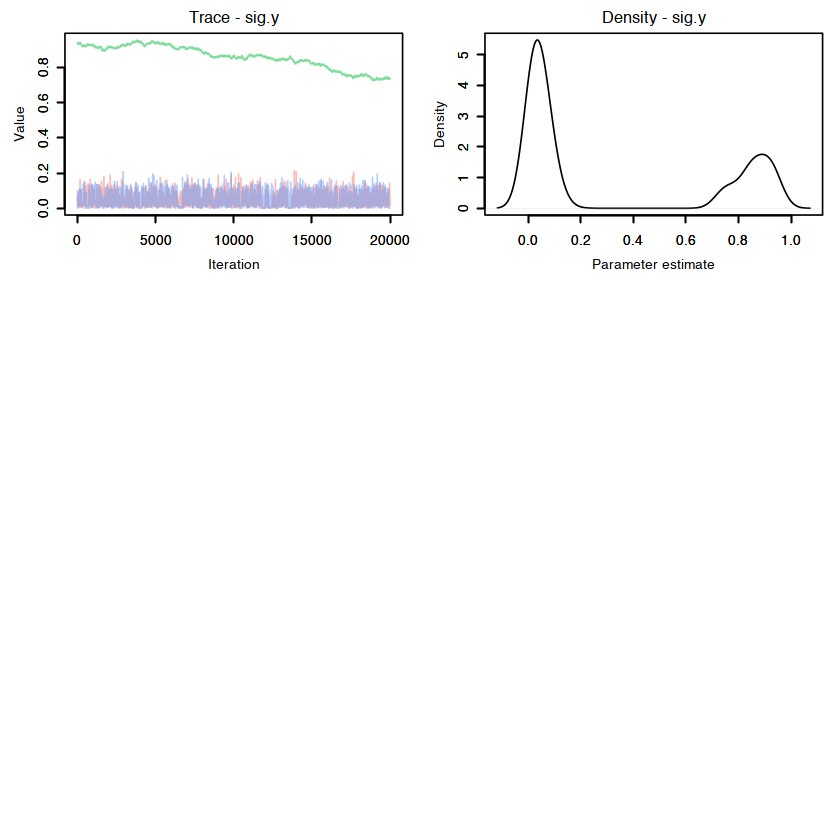

In [164]:
projection <- 6

# Passing in parameters from dataset
model_parameters <- list(
  # Vector of rain quantity observed each year
  rain = wildebeest$rain,
  # Catch - the amount harvested (or illegal poaching)
  # that happened on the wildebeest population
  catch = wildebeest$Catch,
  # Vector of population observations
  # We need to consider a logarithm transformation 
  # as the model is modelling the logarithm of the counts
  # in order to avoid negative values
  y = log(wildebeest$Nhat),
  # Number of years to include in the simulation
  # Each sample will contain nyrs of data
  nyrs = nrow(wildebeest),
  # Initial population estimate
  # We use the logarithm of the initial population
  # when the surveillance of the population started
  N1 = log(wildebeest$Nhat[1])
)


# Initial values
# For the initial values, we will generate randomly
# values to make sure that multiple chains are not
# starting from the same initial configuration.
initial_values <- function() {
  list(
    b0 = runif(1, -2, 2),
    b1 = runif(1, -2, 2),
    sig.n = runif(1, 0, 1),
    sig.y = runif(1, 0, 1)
  )
}

# Parameters that we want to monitor from the model
# b0, b1, sig.n and sig.y will be monitored to see if the
# chains converge to the posterior distribution while N.est
# y.est will be used to draw conclusions. 
monitored_parameters <- c("b0", "b1",  "sig.n", "sig.y", "N.est", "y.est")

# Number of chains that we want to run
nc <- 3
# Number of iterations for burn-in. These
# iteration will be discarded before considering
# summaries or chain convergence diagnostics.
nb <- 100000
# Total number of iterations to run the chain.
# We started with smaller samples and increased
# the values until we got to some satisfactory
# effective sample sizes for the parameters of
# interest.
ni <- 100000 + nb

# Number of thinning samples. This is set to 1
# so no thinning occurs, meaning that we consider
# the posterior samples to be sufficiently independent
# to the point that no thinning is necessary.
nt <- 5

# Start the MCMC algorithm with the parameters provided
out <- jags(
    data = model_parameters,
    inits = initial_values,
    parameters.to.save = monitored_parameters,
    model.file = "project2.txt",
    n.chains = nc,
    n.iter = ni,
    n.burnin = nb,
    n.thin = nt
)

# Draw trace plots and density plots for the monitored parameters
MCMCtrace(
    out,                                 # the fitted model
    params = monitored_parameters[1:4],  # out parameters of interest
    iter = ni,                           # plot all iterations
    pdf = FALSE,                         # don't write to a PDF
    ind = FALSE                          # chain specific densities 
)


In [163]:
out

JAGS output for model 'project2.txt', generated by jagsUI.
Estimates based on 3 chains of 2e+05 iterations,
adaptation = 100 iterations (sufficient),
burn-in = 1e+05 iterations and thin rate = 1,
yielding 3e+05 total samples from the joint posterior. 
MCMC ran for 0.592 minutes at time 2021-11-09 16:00:24.

              mean      sd     2.5%      50%   97.5% overlap0     f  Rhat
b0        -159.804 211.401 -672.156 -118.900 146.978     TRUE 0.762 1.191
b1        -285.503 237.277 -781.882 -256.583  87.581     TRUE 0.899 1.131
sig.n        0.178   0.028    0.130    0.176   0.240    FALSE 1.000 1.000
sig.y        0.041   0.030    0.001    0.036   0.109    FALSE 1.000 1.000
N.est[1]     0.264   0.013    0.239    0.263   0.294    FALSE 1.000 1.000
N.est[2]     0.268   0.013    0.247    0.265   0.302    FALSE 1.000 1.000
N.est[3]     0.352   0.016    0.314    0.355   0.381    FALSE 1.000 1.000
N.est[4]     0.361   0.016    0.331    0.358   0.400    FALSE 1.000 1.000
N.est[5]     0.434   0.01

In [116]:
MCMCsummary(out,
            params = parms[1:4]) #out parameters of interest

,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
b0,-230.054079,228.64797922,-7.534647e+02,-198.83264349,122.1446663,1,1168
b1,-218.540190,218.23331521,-7.138667e+02,-187.43474070,116.5689563,1,700
sig.n,0.175953,0.03078869,1.206997e-01,0.17406696,0.2426413,1,32156
sig.y,0.052216,0.03441784,2.170295e-03,0.04837311,0.1275138,1,4555


In [8]:
data("martin")

In [13]:
b0        -217.495 221.680 -713.997 -186.840 128.628     TRUE 0.839 1.001
b1        -232.505 221.301 -727.850 -202.889 107.952     TRUE 0.860 1.000
sig.n        0.168   0.031    0.111    0.167   0.235    FALSE 1.000 1.000
sig.y        0.057   0.035    0.004    0.054   0.133    FALSE 1.000 1.000

b0        -223.876 225.094 -731.600 -194.657 127.602     TRUE 0.844 1.000
b1        -226.317 219.153 -721.300 -196.048 109.854     TRUE 0.857 1.000
sig.n        0.169   0.031    0.112    0.168   0.236    FALSE 1.000 1.000
sig.y        0.054   0.036    0.002    0.051   0.132    FALSE 1.000 1.002

[1] 5.602119 5.564520 5.733341 5.762051 5.442418 5.375278 5.337538 5.420535
 [9] 5.273000 5.420535 5.451038 5.342334 5.420535 5.257495 5.252273 5.416100
[17] 5.501258 5.323010 5.252273 5.159055